# United States 115th Congress 

Here we have data on each senator and representative in U.S. Congress, credit to [u/Stuck_In_the_Matrix](https://www.reddit.com/r/datasets/comments/6fgg31/complete_information_for_us_115th_congress_google/).
The data includes things such as name, party, chamber, birth date, the year of first entering Congress, state and district numbers, and links to various social media accounts.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
congress = pd.read_csv('U.S. 115th Congress  - Sheet1.csv', index_col=0)

First, we'll parse the birth dates and calculate ages from them.
It looks like ages are distributed somewhat normally, as one might expect.

In [3]:
# Parse the birth dates into date objects
from dateutil.parser import parse
congress['BD'] = congress['Birth Date'].map(parse, na_action='ignore')

In [4]:
# Calculate each congressmember's age
def f(bd):
    result = (pd.Timestamp.today() - bd).days / 365
    if type(result) != float:
        return np.nan
    else:
        return result
congress['Age'] = congress.BD.map(f)

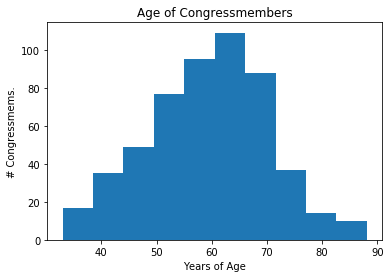

In [5]:
plt.hist(congress.Age.dropna());
plt.title("Age of Congressmembers");
plt.xlabel("Years of Age")
plt.ylabel("# Congressmems.");

Also we'll calculate the number of years each member has so far served.
Here we see an exponential fall-off shape to the data.

In [6]:
# Calculate each congressmember's time in office
def tio(x):
    if x == 'None':
        return np.nan
    else:
        return 2017 - int(x)
congress['TiO'] = congress['Year Entering Congress'].map(tio, na_action='ignore')

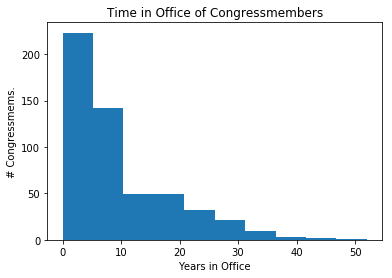

In [7]:
plt.hist(congress.TiO.dropna())
plt.title("Time in Office of Congressmembers");
plt.xlabel("Years in Office")
plt.ylabel("# Congressmems.");

For convenience in our code, we'll go ahead and split the rows up by party, chamber, and gender:

In [8]:
# Split by party
r_all = congress[(congress.Party == 'Republican')]
d_all = congress[(congress.Party == 'Democratic')]
i_all = congress[(congress.Party == 'Independent')]

In [9]:
# Split by chamber
all_sen = congress[(congress.Chamber == 'Senator')].dropna()
all_rep = congress[(congress.Chamber == 'Representative')].dropna()

In [10]:
# Split by party and chamber
r_rep = congress[(congress.Party == 'Republican') & (congress.Chamber == 'Representative')]
r_sen = congress[(congress.Party == 'Republican') & (congress.Chamber == 'Senator')]
d_rep = congress[(congress.Party == 'Democratic') & (congress.Chamber == 'Representative')]
d_sen = congress[(congress.Party == 'Democratic') & (congress.Chamber == 'Senator')]
i_rep = congress[(congress.Party == 'Independent') & (congress.Chamber == 'Representative')]
i_sen = congress[(congress.Party == 'Independent') & (congress.Chamber == 'Senator')]

In [11]:
# Split by gender
female = congress[congress.Gender == 'Female']
male = congress[congress.Gender == 'Male']

First let's look at the distribution of age split by chamber.
We would expect Senators to be older, and the T-test confirms this ($p<0.05$).

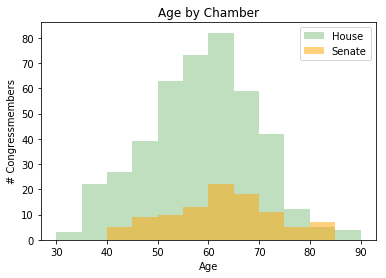

In [12]:
plt.hist(all_rep.Age, alpha = 0.25, color='green', bins=range(30,95,5));
plt.hist(all_sen.Age, alpha = 0.5, color='orange', bins=range(30,95,5));
plt.xlabel("Age")
plt.ylabel("# Congressmembers")
plt.title("Age by Chamber");
plt.legend(["House", "Senate"]);

In [13]:
ttest_ind(all_rep.Age, all_sen.Age)

Ttest_indResult(statistic=-3.4276092959068287, pvalue=0.00065633885778097669)

Now let's look at the distribution of age split by party.
It looks like Democrats tend towards being older.

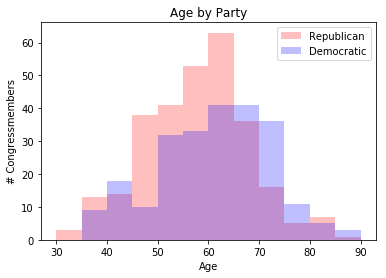

In [14]:
plt.hist(r_all.Age, alpha = 0.25, color='red', bins=range(30,95,5));
plt.hist(d_all.Age, alpha = 0.25, color='blue', bins=range(30,95,5));
plt.xlabel("Age")
plt.ylabel("# Congressmembers")
plt.title("Age by Party");
plt.legend(["Republican", "Democratic"]);

Below we run a T-test on the two parties' ages. It appears that Democrats are "significantly" older ($p<0.05$), but what does this really mean?
For example, perhaps the Democrats simply have more Senate seats than the Republican party, and the Senators tend to be older thus driving up the Democrat's average age.
Let's see whether this is the cause.

In [15]:
from scipy.stats import ttest_ind
ttest_ind(r_all.Age, d_all.Age)

Ttest_indResult(statistic=-3.6612285171626446, pvalue=0.00027632416955651959)

# Average Ages by Party, Chamber, and Gender

To determine what's causing the Democrats to have significantly older Congressmembers,
let's further explore the data by breaking down average age by party, chamber, and gender.

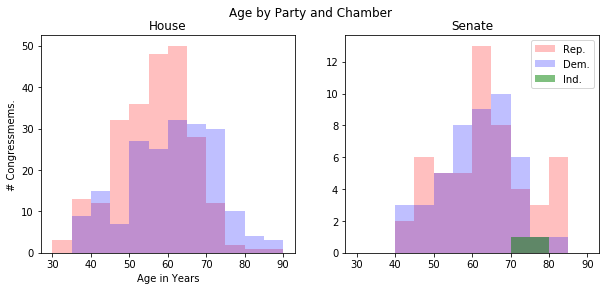

In [16]:
f, (ax,bx) = plt.subplots(1, 2, sharex=True)
ax.set_title("House")
ax.set_ylabel("# Congressmems.")
ax.set_xlabel("Age in Years")
ax.hist(r_rep.Age, alpha=0.25, color='red', bins=range(30,95,5))
ax.hist(d_rep.Age, alpha=0.25, color='blue', bins=range(30,95,5))
ax.hist(i_rep.Age, alpha=0.5, color='green', bins=range(30,95,5))
bx.set_title("Senate")
bx.hist(r_sen.Age, alpha=0.25, color='red', bins=range(30,95,5))
bx.hist(d_sen.Age, alpha=0.25, color='blue', bins=range(30,95,5))
bx.hist(i_sen.Age, alpha=0.5, color='green', bins=range(30,95,5))
bx.legend(["Rep.", "Dem.", "Ind."], loc='upper right')
f.suptitle("Age by Party and Chamber")
f.set_figwidth(10);
f.set_figheight(4);

In the table below, be have the average age split by party, chamber, and gender:

In [17]:
c = congress[['Party', 'Chamber', 'Age', 'Gender']]
c = c[(c.Party == 'Republican') | (c.Party == 'Democratic')]
c.pivot_table(index=['Party', 'Gender'], columns='Chamber', values='Age', aggfunc=np.nanmean).applymap(lambda x: np.round(x, 1))

Chamber            Representative  Senator
Party      Gender                         
Democratic Female            62.7     61.7
           Male              60.4     61.5
Republican Female            55.0     60.3
           Male              56.7     63.5

These suggest that the Democrats in the House are actually older on average than the Republicans, while the Senators of each are about the same age.

The T-tests below support this. Those in the House differ significantly by age ($p<0.05$), but those in the Senate do not ($p>0.05$).

In [18]:
ttest_ind(r_rep.Age, d_rep.Age)

Ttest_indResult(statistic=-4.3921956517671701, pvalue=1.4153623309516426e-05)

In [19]:
ttest_ind(r_sen.Age, d_sen.Age)

Ttest_indResult(statistic=0.748748974181077, pvalue=0.45583913671686282)

We've disproved hypothesis that the age difference between parties was simply due to disproportionate amounts in each chamber.

So then why are Democrats older?
Perhaps only Democrats who had more time in office, and thus were older, were able to get elected this term.
Let's look into that next.

# Time in Office

Let's begin by looking at the relationship between age and time in office.
Not surprisingly, there's a strong positive correlation: the more time in office one has served, the older they must be.

In [20]:
c = congress.dropna(subset=['TiO','Age'])
model = sm.OLS(c.TiO, sm.add_constant(c.Age))
res = model.fit()
print("p-value: {}".format(res.pvalues.Age))

p-value: 1.971560010019679e-51


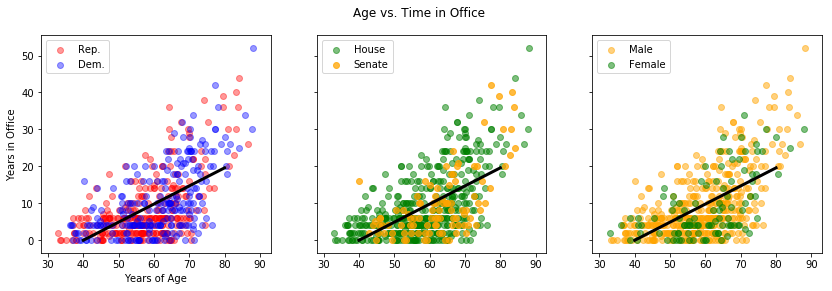

In [21]:
f, (ax,bx,cx) = plt.subplots(1,3, sharex=True, sharey=True)
ax.scatter(r_all.Age, r_all.TiO, alpha=0.4, color='red');
ax.scatter(d_all.Age, d_all.TiO, alpha=0.4, color='blue');
ax.legend(["Rep.", "Dem."]);
ax.set_xlabel("Years of Age");
ax.set_ylabel("Years in Office");
bx.scatter(all_rep.Age, all_rep.TiO, alpha=0.5, color='green');
bx.scatter(all_sen.Age, all_sen.TiO, alpha=0.75, color='orange');
bx.legend(["House", "Senate"]);
cx.scatter(male.Age, male.TiO, alpha=0.5, color='orange');
cx.scatter(female.Age, female.TiO, alpha=0.5, color='green');
cx.legend(["Male", "Female"]);

x = [40, 80]
y = res.predict([[1,x[0]],[1,x[1]]])
ax.plot(x,y, color='black', linewidth=3)
bx.plot(x,y, color='black', linewidth=3)
cx.plot(x,y, color='black', linewidth=3)

f.set_figwidth(14);
f.set_figheight(4);
f.suptitle("Age vs. Time in Office");

With this correlation in mind, let's break down time in office by party and chamber.

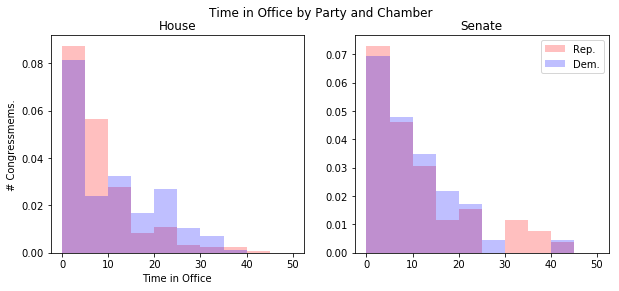

In [22]:
f, (ax,bx) = plt.subplots(1, 2, sharex=True)
ax.set_title("House")
ax.set_ylabel("# Congressmems.")
ax.set_xlabel("Time in Office")
ax.hist(r_rep.TiO, alpha=0.25, color='red', bins=range(0,55,5), normed=True)
ax.hist(d_rep.TiO, alpha=0.25, color='blue', bins=range(0,55,5), normed=True)
#ax.hist(i_rep.TiO, alpha=0.5, color='green', bins=range(0,55,5), normed=True)
bx.set_title("Senate")
bx.hist(r_sen.TiO, alpha=0.25, color='red', bins=range(0,55,5), normed=True)
bx.hist(d_sen.TiO, alpha=0.25, color='blue', bins=range(0,55,5), normed=True)
#bx.hist(i_sen.TiO, alpha=0.5, color='green', bins=range(0,55,5), normed=True)
bx.legend(["Rep.", "Dem."], loc='upper right')
f.suptitle("Time in Office by Party and Chamber")
f.set_figwidth(10);
f.set_figheight(4);

In the table below, be have the average time in office split by party and chamber:

In [23]:
c = congress[['Party', 'Chamber', 'TiO']]
c = c[(c.Party == 'Republican') | (c.Party == 'Democratic')]
c.pivot_table(index='Party', columns='Chamber', values='TiO', aggfunc=np.nanmean).applymap(lambda x: np.round(x, 1))

Chamber,Representative,Senator
Party,,
Democratic,11.1,9.5
Republican,7.8,10.5


So perhaps the reason that Democrats tend to be older is simply that in order to get elected this term, they needed greater political experience (i.e. greater time in office) to win over the Republican surge.